# 데이터 전처리 및 Feature 구성 요약

#### Feature 타입 구성
- 수치형 feature 개수: 85
- 범주형 feature 개수: 1
- 범주형 feature 목록:
  - `gender`: 3개 클래스 (male, female, unknown)

---

#### 전처리 단계 (컬럼 정리 및 파생)

- 중복 컬럼 제거:
  - `bd`와 `bd_clean`이 동시에 존재할 경우
    - `bd` 컬럼 제거

- 시간 관련 컬럼 처리:
  - `registration_init_time`로부터 파생:
    - `reg_year` (연도, Int64)

- 원본 컬럼 제거:
  - `registration_init_time`
  - `registration_month`
  - 목적: Datetime / Period 타입으로 인한 후속 처리 오류 방지

---

#### 전처리 파이프라인 구성

- Feature 타입 분리 기준:
  - 수치형(`num_cols`): `is_numeric_dtype == True`
  - 범주형(`cat_cols`): 수치형이 아닌 feature

- 수치형 feature 전처리:
  - 결측치 처리: `SimpleImputer(strategy="median")`
  - 스케일링: 미적용

- 범주형 feature 전처리:
  - 결측치 처리: `SimpleImputer(strategy="most_frequent")`
  - 인코딩:
    - `OneHotEncoder`
    - `handle_unknown="ignore"`
    - `sparse_output=True`

- 전처리 통합 방식:
  - `ColumnTransformer`
    - 수치형: 중앙값 대체
    - 범주형: 최빈값 대체 → One-Hot Encoding
  - `remainder="drop"`

- 적용 범위:
  - train / validation / test 데이터에만 적용
  - inference 단계는 본 실험 범위에 포함되지 않음

---

#### 전처리 결과 Feature 차원 확인
 > - Split-based feature_importance는 OHE 이후 변환 feature 기준(85 + 3개)<br>
 > - Permutation importance는 원본 입력 컬럼 기준(86개)

- 전처리 후 validation feature matrix 차원:
  - `Xv.shape[1] = 86`

- Permutation importance 대상 feature 개수:
  - `len(perm.importances_mean) = 86`

- 전처리 파이프라인 출력 feature 개수:
  - `len(prep.get_feature_names_out()) = 88`

# 데이터 분할 설정

- 분할 방식:
  - Stratified random split (`stratify = is_churn`)
  - `random_state = 719`

- 분할 비율:
  - Train: 70% (602,676 × 86)
  - Validation: 15% (129,145 × 86)
  - Test: 15% (129,145 × 86)

- 분할 기준:
  - user-level feature table 기준
  - 각 행은 고유 사용자(msno)를 나타냄

# RandomForest Hyperparameters

- 모델: `sklearn.ensemble.RandomForestClassifier`

- 하이퍼파라미터:
  - `n_estimators`: 5000
  - `max_depth`: None
  - `min_samples_leaf`: 1
  - `min_samples_split`: 2
  - `max_features`: "sqrt"
  - `class_weight`: "balanced"
  - `n_jobs`: -1
  - `random_state`: 719

# Score (vaild/test)

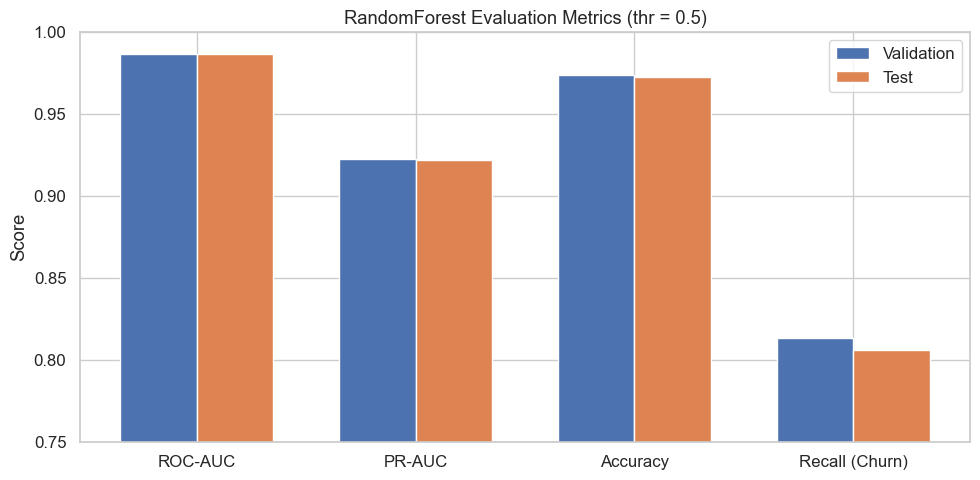

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터
metrics_df = pd.DataFrame({
    "dataset": ["Validation", "Test"],
    "ROC-AUC": [0.986624, 0.986571],
    "PR-AUC":  [0.922345, 0.922095],
    "Accuracy": [0.9735, 0.9726],
    "Recall (Churn)": [0.8135, 0.8063],
})

# long format 변환
metrics_long = metrics_df.melt(
    id_vars="dataset",
    var_name="metric",
    value_name="score",
)

# -----------------
# Bar plot (single axes)
# -----------------
plt.figure(figsize=(10, 5))

for i, dataset in enumerate(metrics_long["dataset"].unique()):
    subset = metrics_long[metrics_long["dataset"] == dataset]
    x = range(len(subset))
    plt.bar(
        [v + i * 0.35 for v in x],
        subset["score"],
        width=0.35,
        label=dataset,
    )

plt.xticks(
    [v + 0.175 for v in range(len(subset))],
    subset["metric"],
    rotation=0,
)

plt.ylim(0.75, 1.0)
plt.ylabel("Score")
plt.title("RandomForest Evaluation Metrics (thr = 0.5)")
plt.legend()
# plt.grid(axis="y", alpha=0.3)
plt.savefig("../images/models/rf/fig_rf_metrics_scores.png", dpi=300)
plt.tight_layout()
plt.show()

# Confusion matrix (vaild/test)

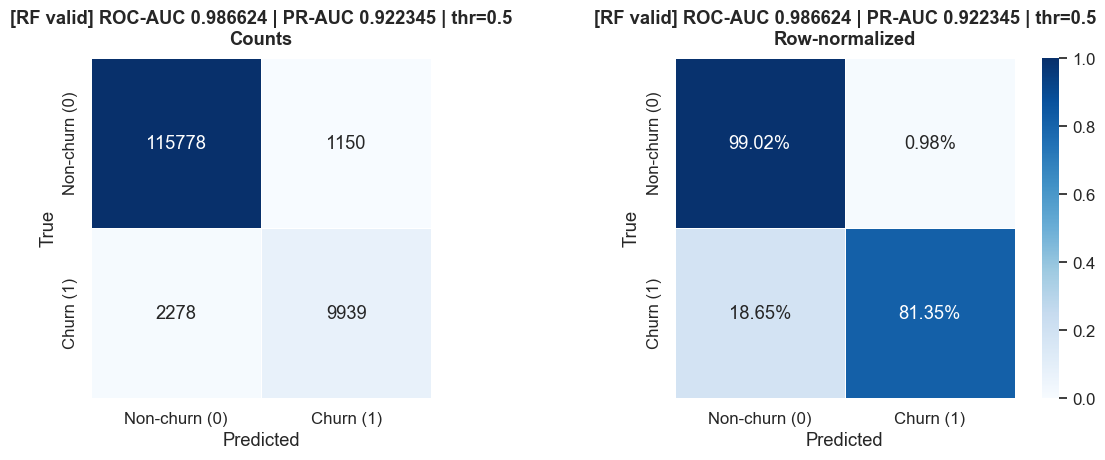

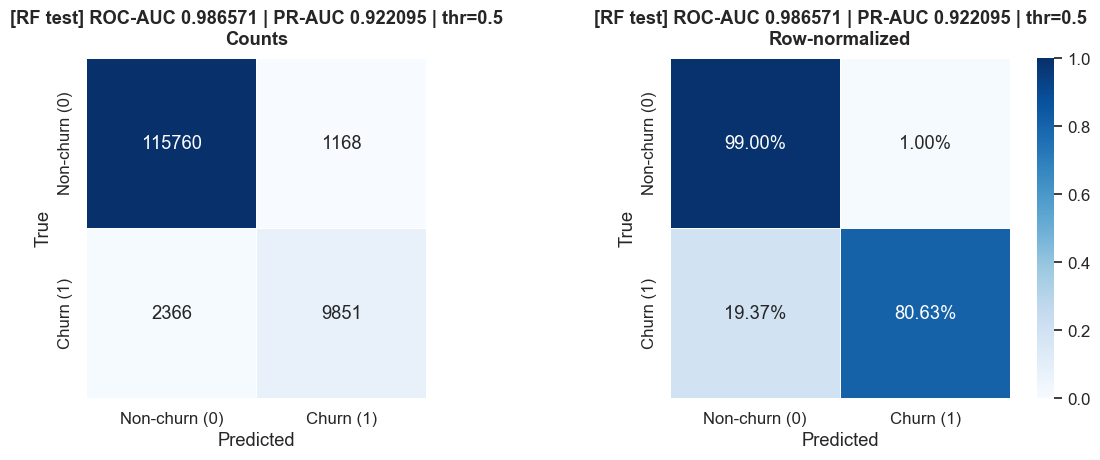

In [18]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrices(
    cm: np.ndarray,
    title: str,
    labels=("Non-churn (0)", "Churn (1)"),
    save_path: str | None = None,
):
    """
    cm: shape (2,2) confusion matrix in form:
        [[TN, FP],
         [FN, TP]]
    """
    sns.set_theme(style="white", font_scale=1.1)

    cm = np.array(cm, dtype=int)
    cm_norm = cm / cm.sum(axis=1, keepdims=True)  # row-normalized

    fig, axes = plt.subplots(1, 2, figsize=(12, 4.8))

    # --- (1) Raw counts ---
    ax = axes[0]
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        linewidths=0.5,
        linecolor="white",
        square=True,
        xticklabels=labels,
        yticklabels=labels,
        ax=ax,
    )
    ax.set_title(f"{title}\nCounts", weight="bold", pad=10)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

    # --- (2) Row-normalized (recall view) ---
    ax = axes[1]
    sns.heatmap(
        cm_norm,
        annot=True,
        fmt=".2%",
        cmap="Blues",
        cbar=True,
        linewidths=0.5,
        linecolor="white",
        square=True,
        xticklabels=labels,
        yticklabels=labels,
        vmin=0,
        vmax=1,
        ax=ax,
    )
    ax.set_title(f"{title}\nRow-normalized", weight="bold", pad=10)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()


# =========================
# Your confusion matrices
# =========================
cm_valid = np.array([[115778, 1150],
                     [  2278, 9939]])

cm_test  = np.array([[115760, 1168],
                     [  2366, 9851]])

plot_confusion_matrices(
    cm_valid,
    title="[RF valid] ROC-AUC 0.986624 | PR-AUC 0.922345 | thr=0.5",
    save_path="../images/models/rf/fig_rf_confusion_valid.png",
)

plot_confusion_matrices(
    cm_test,
    title="[RF test] ROC-AUC 0.986571 | PR-AUC 0.922095 | thr=0.5",
    save_path="../images/models/rf/fig_rf_confusion_test.png",
)

# Feature Importances (Top 20)

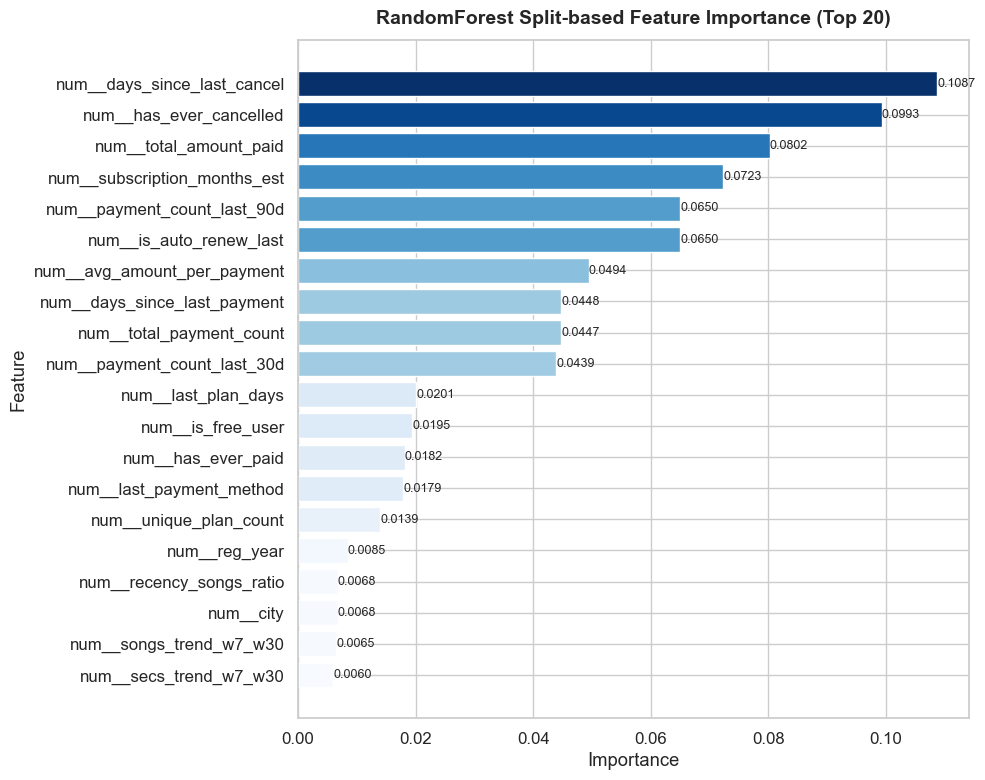

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize

# ===============================
# Load data
# ===============================
fi = pd.read_csv("../data/model_df/rf_feature_importance_split_preprocessed88.csv")

fi_top20 = (
    fi.sort_values("importance", ascending=False)
      .head(20)
      .iloc[::-1]
)

# ===============================
# Color mapping (importance → color)
# ===============================
norm = Normalize(
    vmin=fi_top20["importance"].min(),
    vmax=fi_top20["importance"].max(),
)
colors = cm.Blues(norm(fi_top20["importance"].values))

# ===============================
# Plot
# ===============================
sns.set_theme(style="whitegrid", font_scale=1.1)

plt.figure(figsize=(10, 8))
ax = plt.gca()

ax.barh(
    fi_top20["feature"],
    fi_top20["importance"],
    color=colors,
)

ax.set_title(
    "RandomForest Split-based Feature Importance (Top 20)",
    fontsize=14,
    weight="bold",
    pad=12,
)
ax.set_xlabel("Importance")
ax.set_ylabel("Feature")

# value label
for i, v in enumerate(fi_top20["importance"]):
    ax.text(
        v,
        i,
        f"{v:.4f}",
        va="center",
        ha="left",
        fontsize=9,
    )

plt.tight_layout()
plt.savefig("../images/models/rf/fig_rf_split_importance_top20.png", dpi=300, bbox_inches="tight")
plt.show()

# Permutation Importance (Top 20, mean 기준 색상 + error bar)

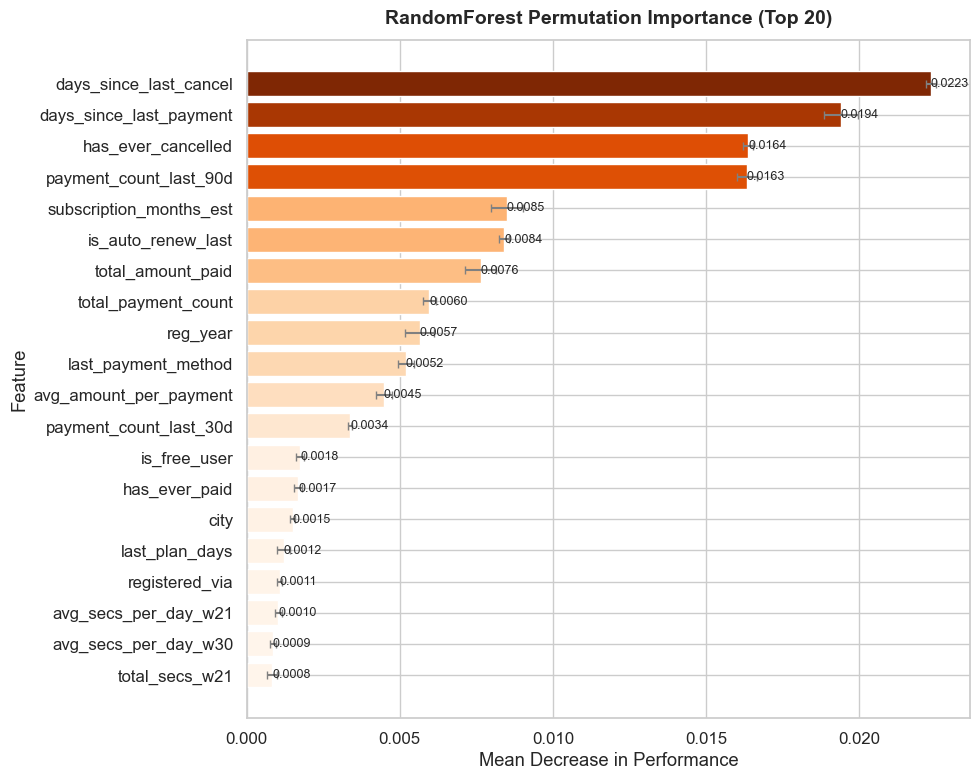

In [20]:
from matplotlib.colors import Normalize
from matplotlib import cm

# ===============================
# Load data
# ===============================
pi = pd.read_csv("../data/model_df/rf_perm_input86_top.csv")

pi_top20 = (
    pi.sort_values("perm_importance_mean", ascending=False)
      .head(20)
      .iloc[::-1]
)

# ===============================
# Color mapping (mean → color)
# ===============================
norm = Normalize(
    vmin=pi_top20["perm_importance_mean"].min(),
    vmax=pi_top20["perm_importance_mean"].max(),
)
colors = cm.Oranges(norm(pi_top20["perm_importance_mean"].values))

# ===============================
# Plot
# ===============================
sns.set_theme(style="whitegrid", font_scale=1.1)

plt.figure(figsize=(10, 8))
ax = plt.gca()

ax.barh(
    pi_top20["feature"],
    pi_top20["perm_importance_mean"],
    xerr=pi_top20["perm_importance_std"],
    color=colors,
    ecolor="gray",
    capsize=3,
)

ax.set_title(
    "RandomForest Permutation Importance (Top 20)",
    fontsize=14,
    weight="bold",
    pad=12,
)
ax.set_xlabel("Mean Decrease in Performance")
ax.set_ylabel("Feature")

# value label
for i, v in enumerate(pi_top20["perm_importance_mean"]):
    ax.text(
        v,
        i,
        f"{v:.4f}",
        va="center",
        ha="left",
        fontsize=9,
    )

plt.tight_layout()
plt.savefig("../images/models/rf/fig_rf_permutation_importance_top20.png", dpi=300, bbox_inches="tight")
plt.show()